In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_qqplot import pplot
import statsmodels.api as sm
import pingouin as pg

from scipy.stats import trim_mean

default_font_size = 18
plt.rcParams.update({'font.size': default_font_size})

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [40]:
population_size = 45
num_faces = 32

# Useful Function

In [41]:
def extract_population_response(df, model_idx, col):
    """
    df: the dataframe to extract the responses from
    model_idx: which model we want
    col: the column index of responses we want

    The dataframe was made in the following format
                feat 1 | feat 2 | feat 3 ...
    ------------------------------------------
            |      
    model 0 |
            |
    ------------------------------------------
            |
    model 1 |
            |
    ...
    """
    series = df[col] #the 
    return series.iloc[model_idx*num_faces:(model_idx+1)*num_faces]

In [42]:
def create_mean_df(df, proportiontocut=0.2):
    new_df = pd.DataFrame(0, index=np.arange(population_size), columns=list(df.columns)+["model_idx"])

    for model_idx in range(population_size):
        for col_idx, col in enumerate(df.columns):
            series = extract_population_response(df, model_idx, col)
            ave_response = trim_mean(series, proportiontocut=proportiontocut)
            new_df.at[model_idx, col] = ave_response
            new_df.at[model_idx, 'model_idx'] = model_idx
    return new_df

In [43]:
def pairwise_anova(df, cols, dv, within, subject, correction, detailed):
    results = []
    
    for i in range(len(cols)-1):
        for j in range(i+1, len(cols)):
            temp = df[(df[within]==cols[i]) | (df[within]==cols[j])]
            
            res = pg.rm_anova(data=temp, dv=dv, within=within, subject=subject, 
                  correction=correction, detailed=detailed)

            results.append((cols[i], cols[j], res))
    return results

In [44]:
def extract_outliers(series):
    #given a pd.Series, extract the indices of the outliers
    # outliers are points x such that:
    # x > Q3 + 1.5*IQR
    # x < Q1 - 1.5*IQR
    # IQR = Q3-Q1
    # Q1, 25th percentile
    # Q3, 75th percentile
    Q1 = series.quantile(q=0.25, interpolation='linear')
    Q3 = series.quantile(q=0.75, interpolation='linear')
    IQR = Q3 - Q1
    return series.index[(series > Q3 + 1.5*IQR) | (series < Q1 - 1.5*IQR)]

# Load Data

In [45]:
df_feature_combination = pd.read_csv("feature_combinations_june_14_no_reflections.csv", index_col=0)

In [46]:
df_feature_combination.head()

,1 Eye,2 Eyes,"1 Eye, Nose","1 Eye, Mouth","2 Eyes, Nose","1 Eye, Nose, Mouth",Full Face,"2 Eyes, Mouth"
0,15.305,12.525,14.040,13.655,11.990,12.260,10.535,11.495
1,15.160,13.115,14.175,13.055,12.410,12.570,11.090,11.410
2,15.295,12.880,13.770,12.335,12.625,11.285,11.550,11.885
3,15.535,12.650,13.080,12.870,11.990,12.940,11.035,12.375
4,15.800,13.215,13.810,13.180,11.995,12.900,10.885,11.680


In [47]:
df_mean_responses = create_mean_df(df_feature_combination, proportiontocut=0)
df_mean_responses.round(2).head()

,1 Eye,2 Eyes,"1 Eye, Nose","1 Eye, Mouth","2 Eyes, Nose","1 Eye, Nose, Mouth",Full Face,"2 Eyes, Mouth",model_idx
0,15.02,12.82,13.90,13.41,12.00,12.51,10.95,11.64,0
1,15.28,12.92,14.00,13.53,11.99,12.52,10.91,11.66,1
2,15.16,12.93,14.10,13.74,12.15,12.87,11.24,11.89,2
3,16.96,14.32,15.80,14.57,13.48,13.71,11.98,12.60,3
4,14.80,13.02,13.76,13.28,12.21,12.44,11.18,11.83,4


## Plotting

In [48]:
temp_cols = ['1 Eye', '2 Eyes', '1 Eye, Nose', '1 Eye, Mouth', '2 Eyes, Nose',
       '1 Eye, Nose, Mouth', '2 Eyes, Mouth', 'Full Face']

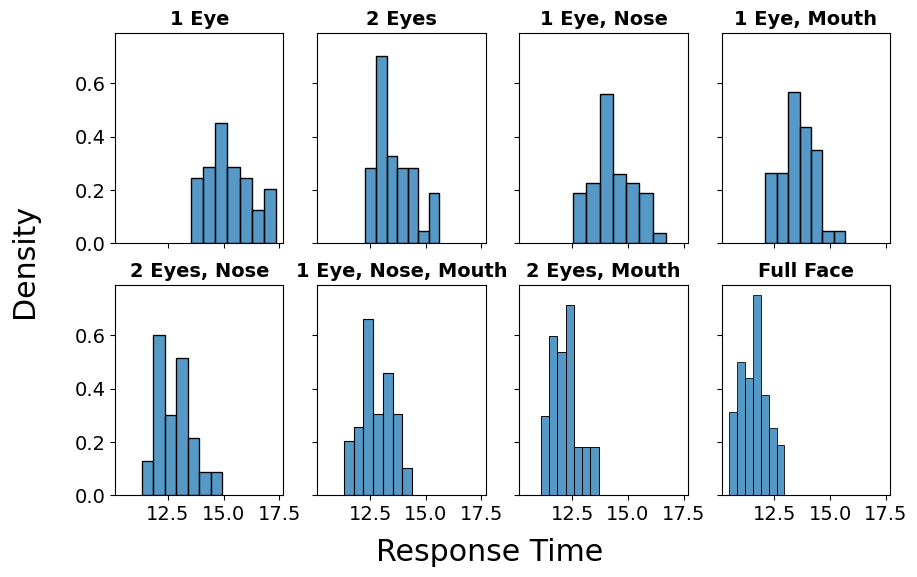

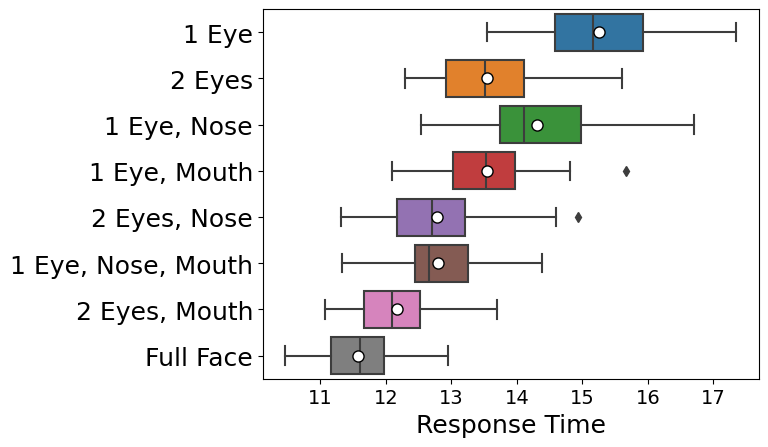

In [49]:
include_outliers = True

if include_outliers: #include everything
    df_subset = df_mean_responses[temp_cols]
else:
    df_subset = df_mean_responses[temp_cols].copy()
    for col in df_subset.columns:
        indices = extract_outliers(df_subset[col])
        df_subset[col][indices] = np.nan

fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(10, 6))

for i in range(len(df_subset.columns)):
    sns.histplot(df_subset, x=df_subset.columns[i], stat="density", ax=axes[i//4, i%4]).set(ylabel="")
    axes[i//4, i%4].set_title(df_subset.columns[i], fontsize=14, weight='bold')
    axes[i//4, i%4].set_xlabel("")
#axes[-1, 0].set_xlabel("Response Time", fontsize=default_font_size)
#axes[-1, 1].set_xlabel("Response Time", fontsize=default_font_size)
fig.supylabel("Density", x=0.02)
fig.supxlabel("Response Time", y=-0.01)
for ax in axes.flatten():
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
plt.savefig("comb_hist.svg", format="svg")
plt.show()

#boxplot
fig, ax = plt.subplots()
sns.boxplot(df_mean_responses[temp_cols], orient="h", showfliers=include_outliers,
            showmeans=True,
            meanprops={'marker':'o',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'})
#ax.tick_params(axis='x', labelrotation=30)
#plt.title(f"{args.test_convergence_norm} Convergence", fontsize=14, weight="bold")
plt.xlabel("Response Time", fontsize=default_font_size)
ax.tick_params(axis='x', labelsize=14)
#ax.tick_params(axis='y', labelsize=14)
plt.savefig("comb_boxplot.svg", format="svg")
plt.show()

In [50]:
for col in temp_cols:
    print(f"{col} & {df_mean_responses[col].mean():.2f} & {df_mean_responses[col].std():.2f} \\\\")

1 Eye & 15.26 & 1.02 \\
2 Eyes & 13.54 & 0.86 \\
1 Eye, Nose & 14.31 & 0.94 \\
1 Eye, Mouth & 13.54 & 0.77 \\
2 Eyes, Nose & 12.78 & 0.80 \\
1 Eye, Nose, Mouth & 12.79 & 0.70 \\
2 Eyes, Mouth & 12.17 & 0.64 \\
Full Face & 11.57 & 0.60 \\


In [111]:
from scipy.stats import skewtest
skewtest(df_mean_responses["2 Eyes"].to_numpy())

SkewtestResult(statistic=2.2022129921919706, pvalue=0.027650266749284485)

## Histograms

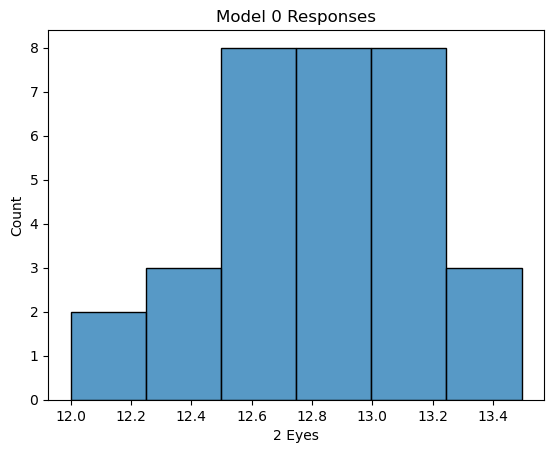

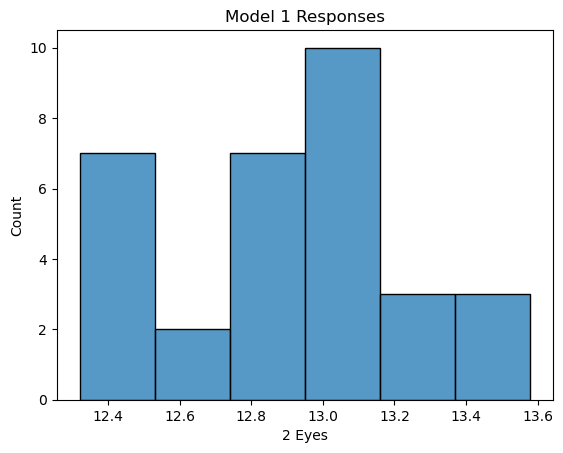

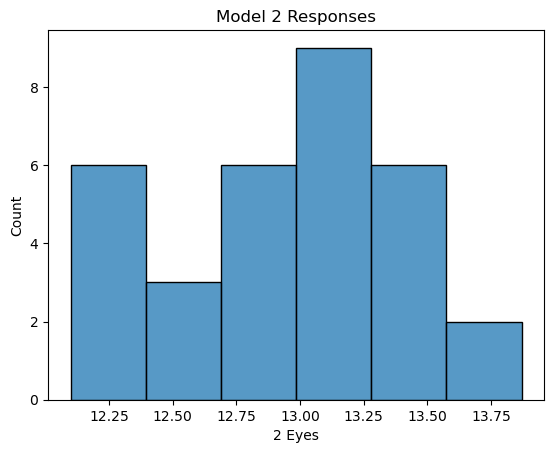

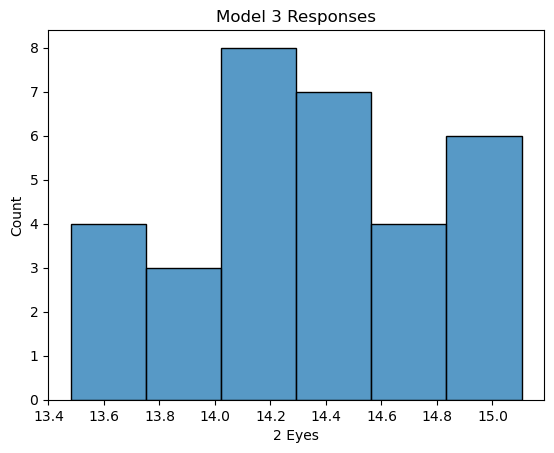

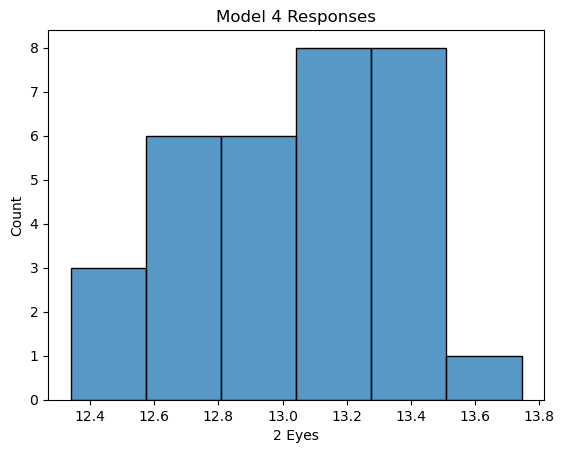

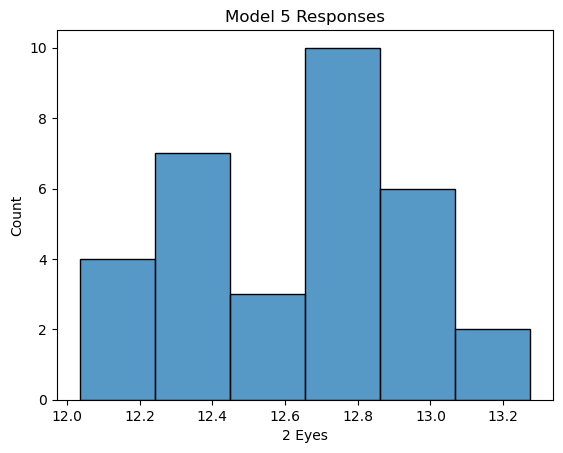

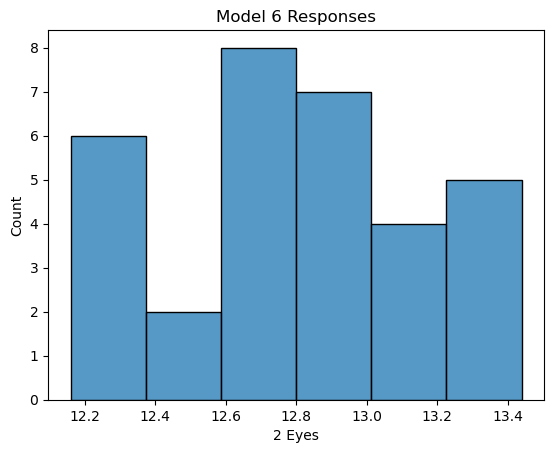

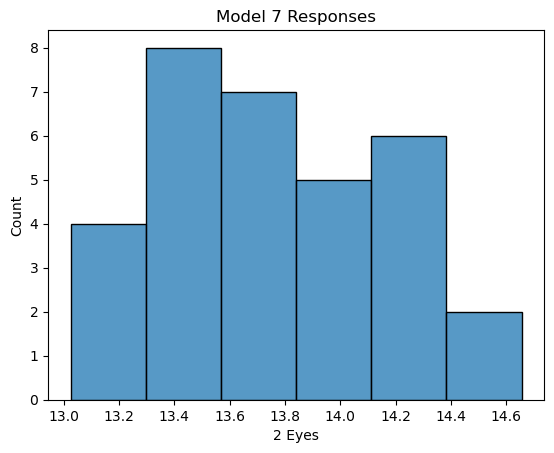

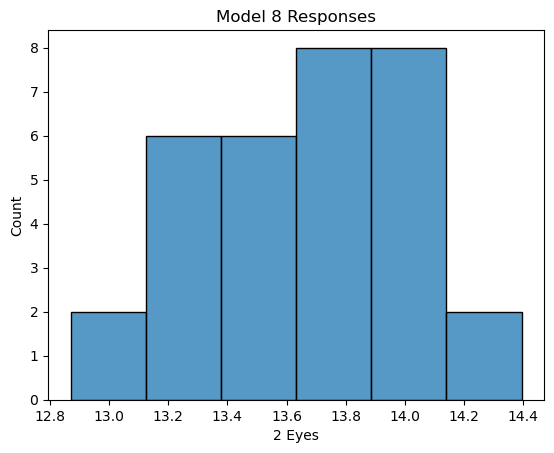

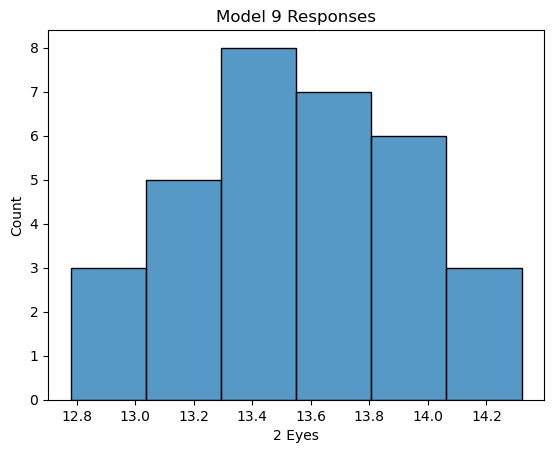

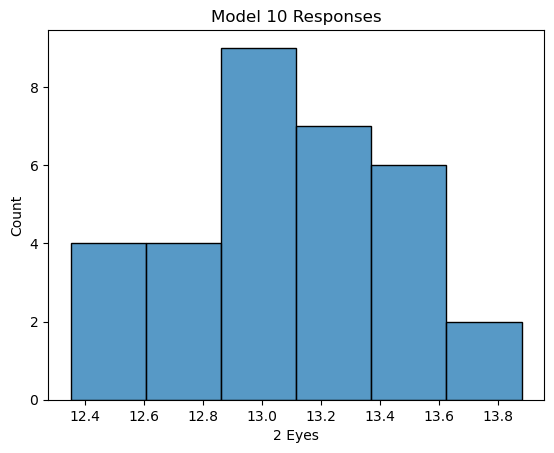

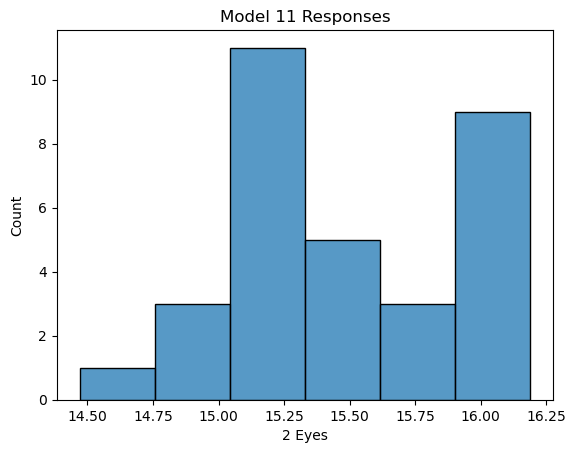

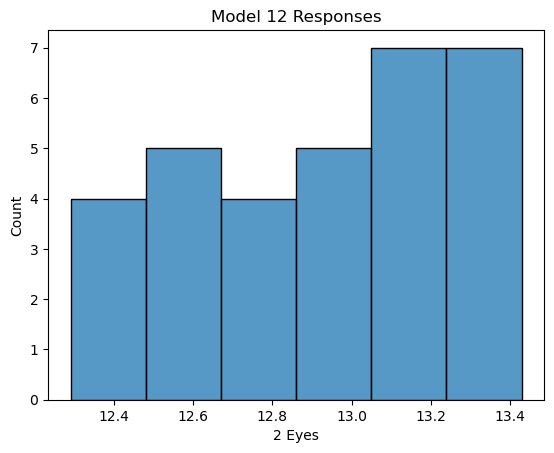

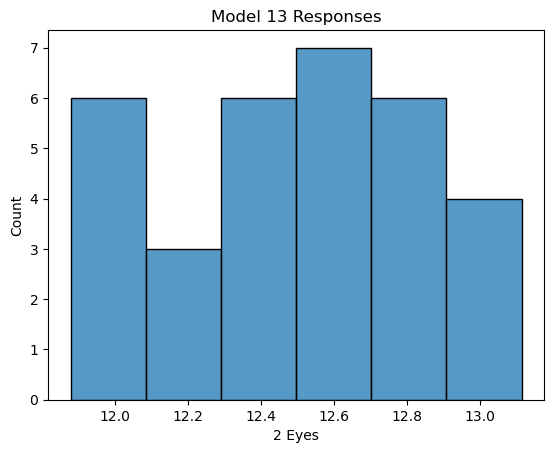

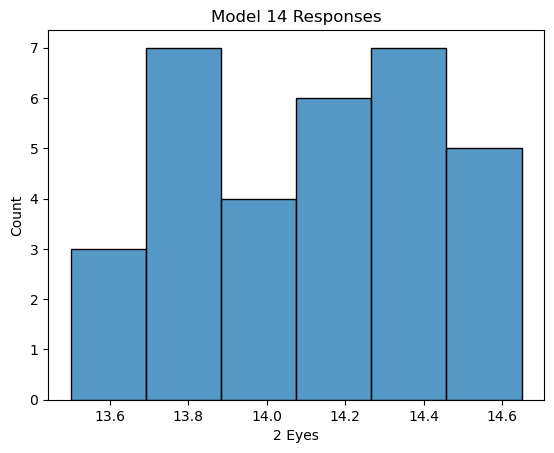

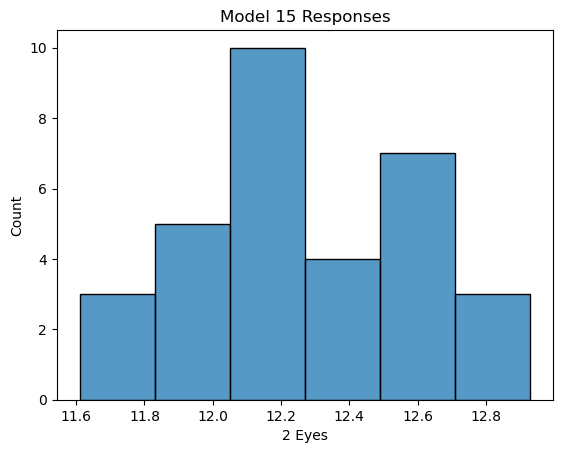

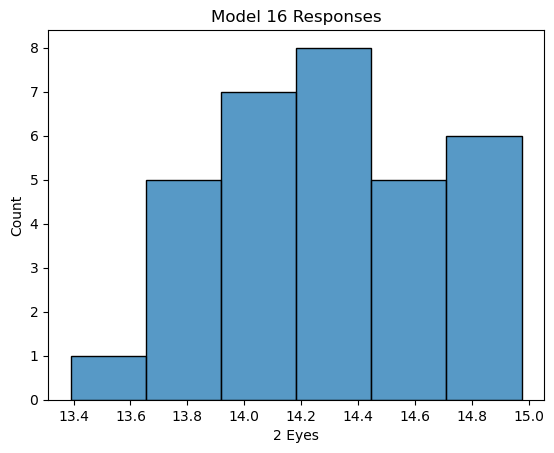

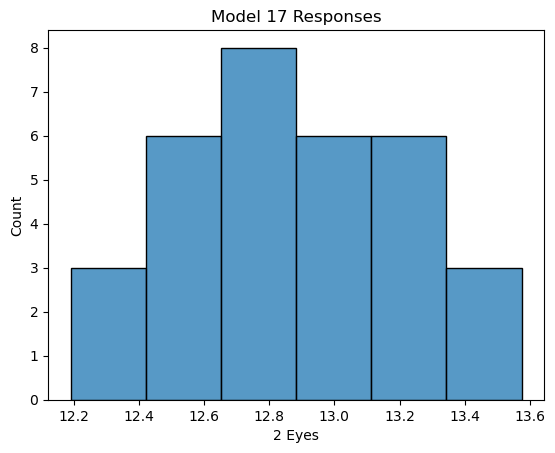

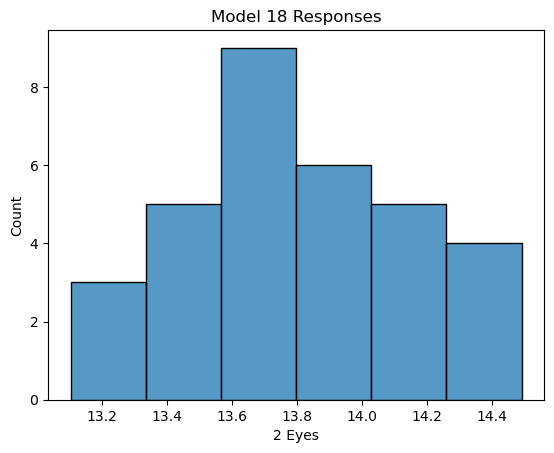

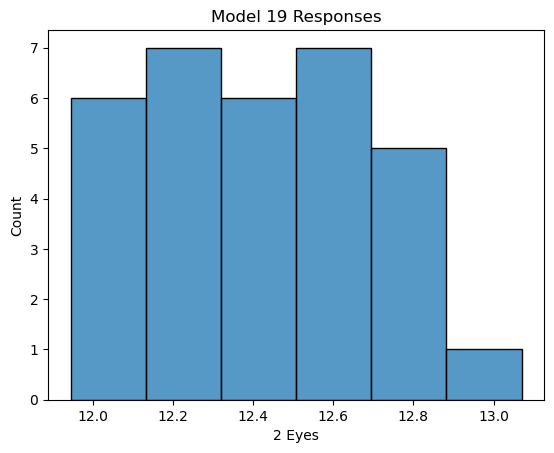

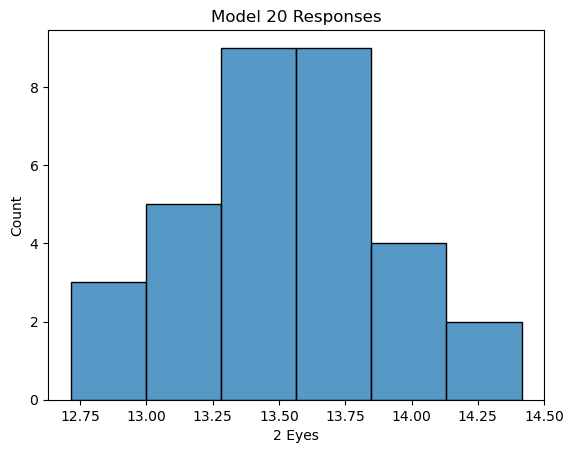

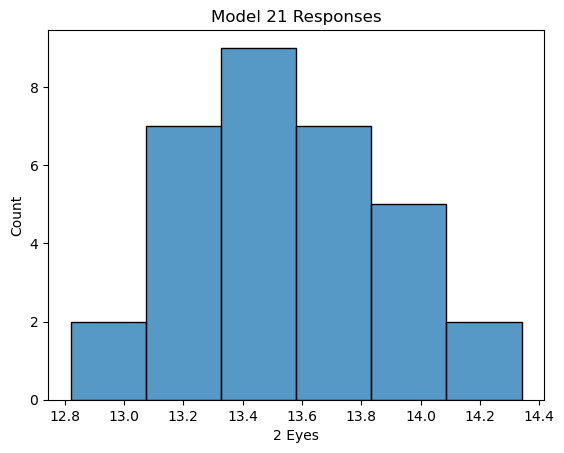

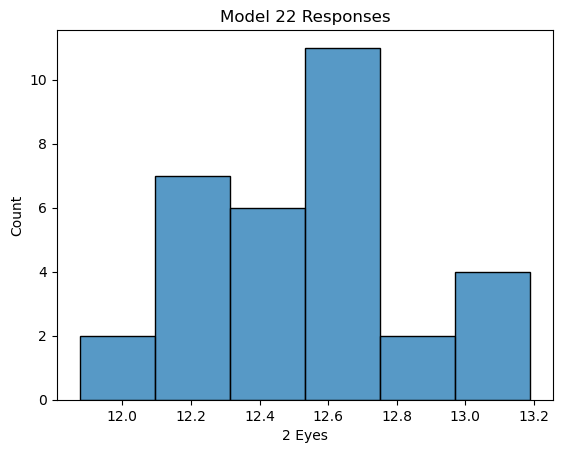

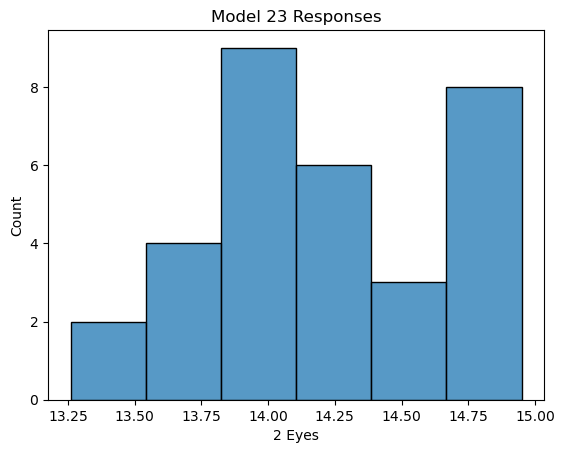

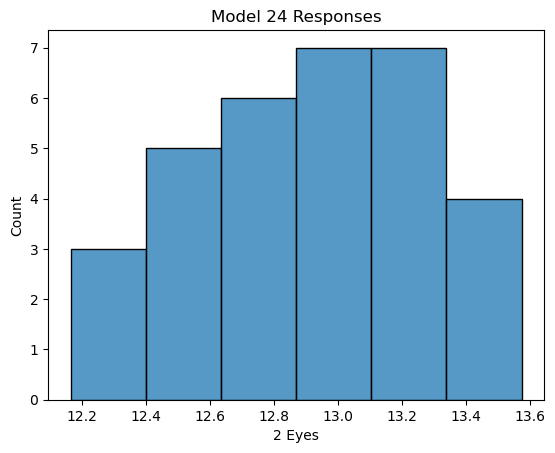

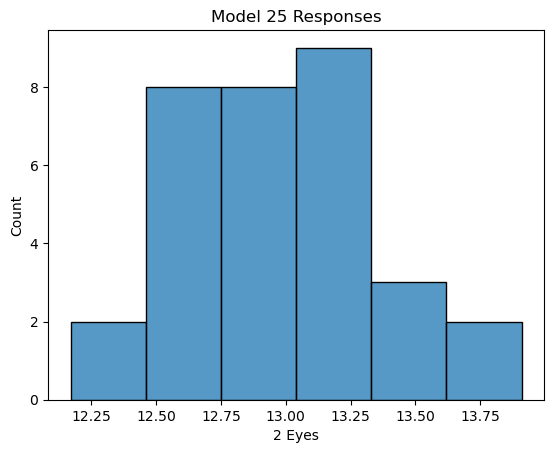

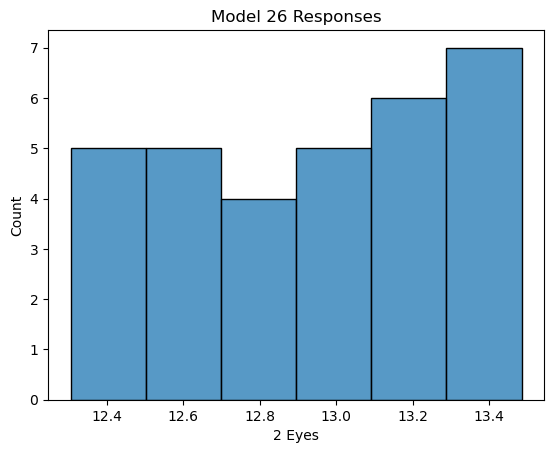

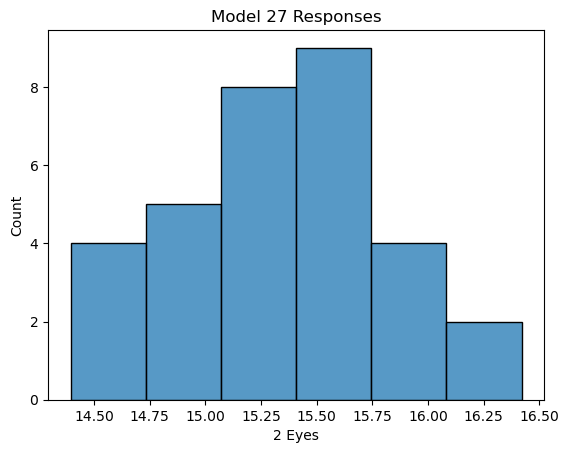

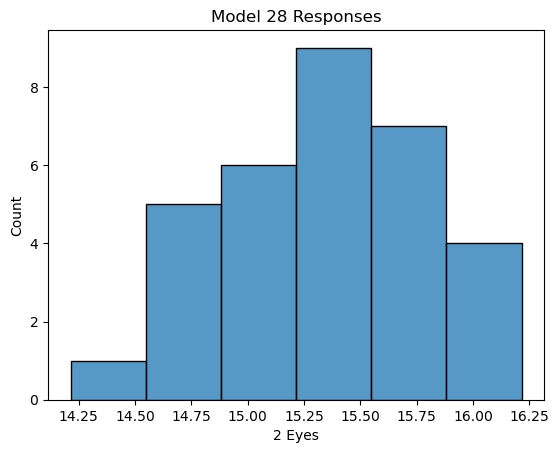

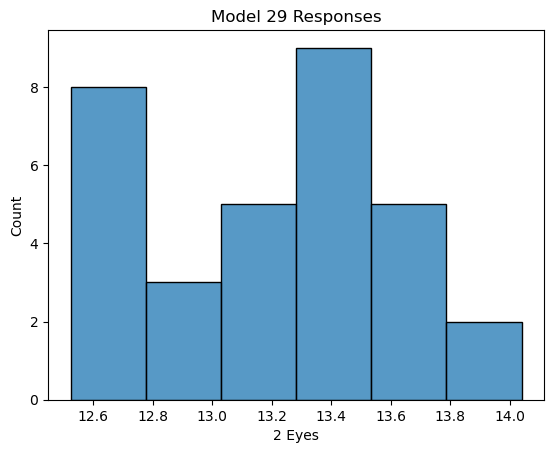

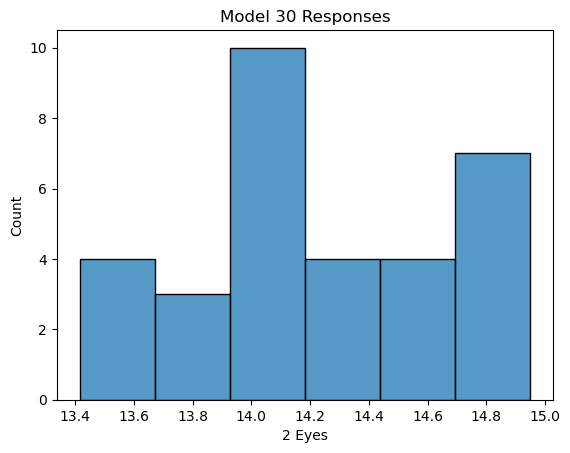

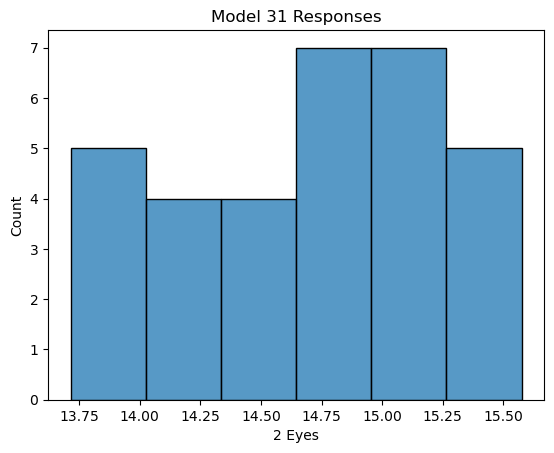

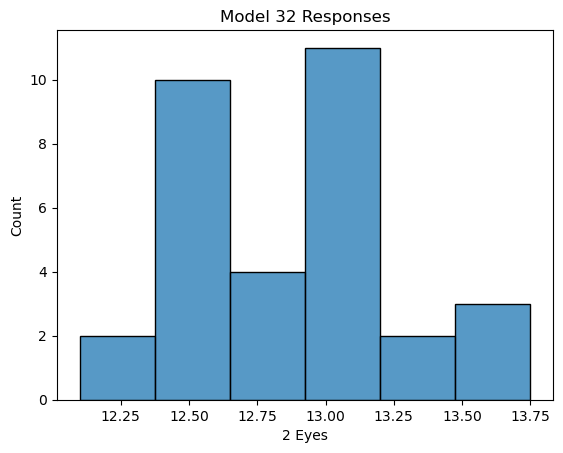

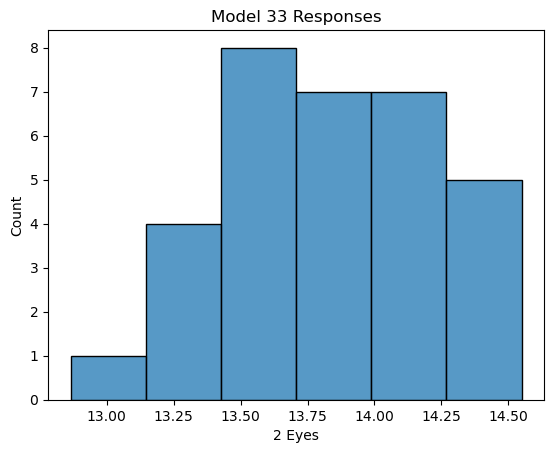

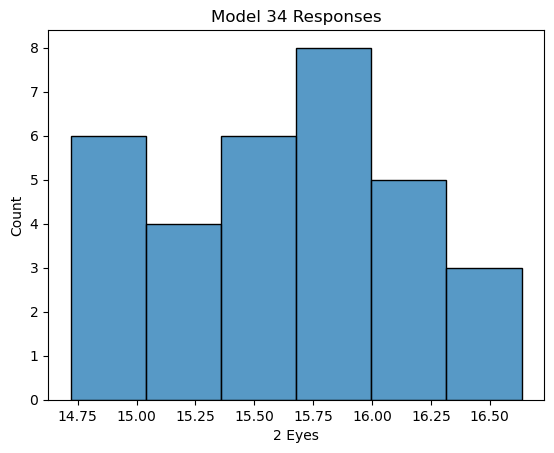

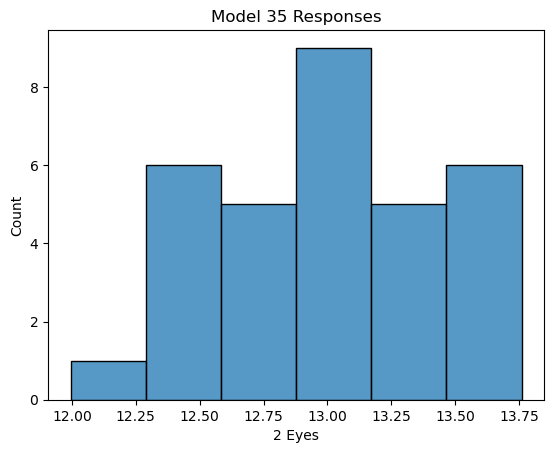

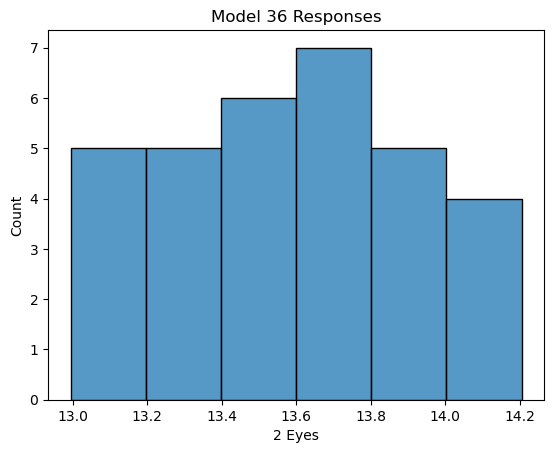

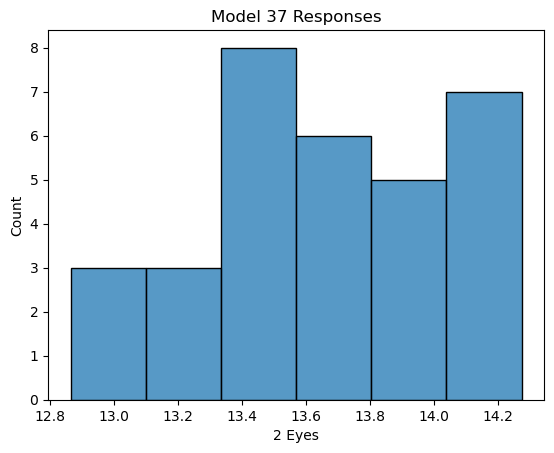

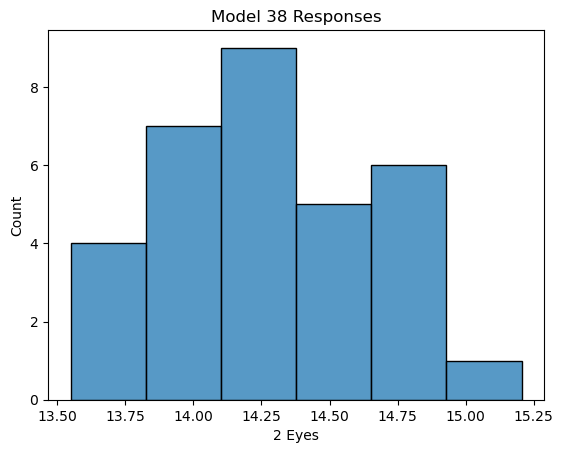

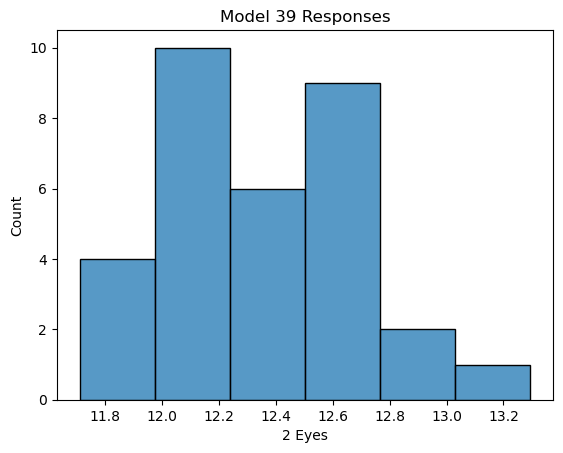

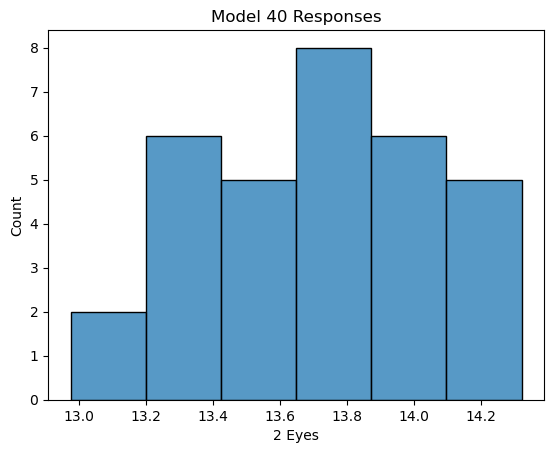

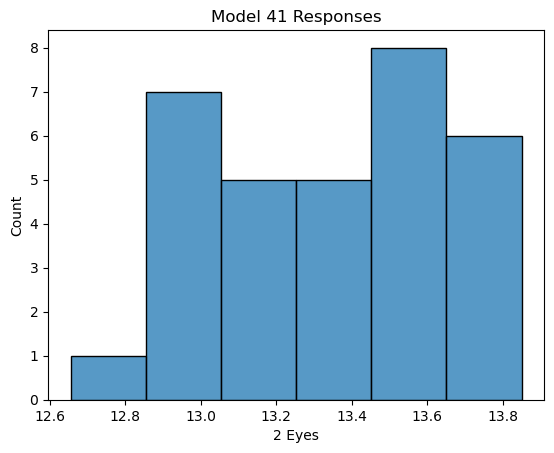

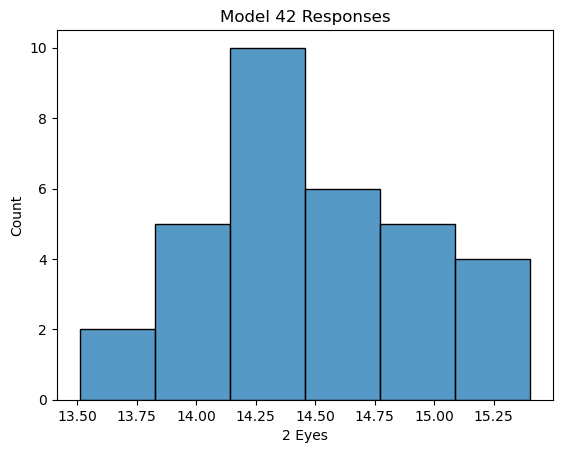

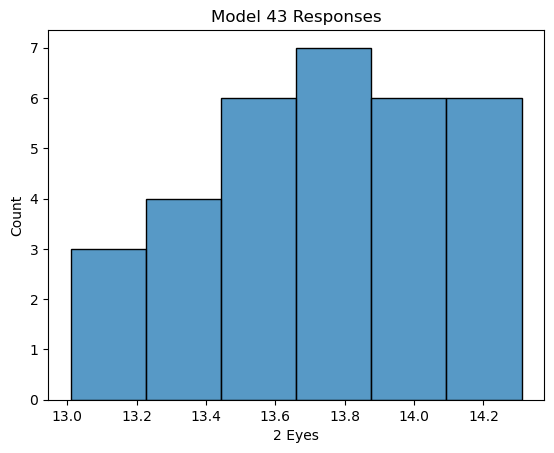

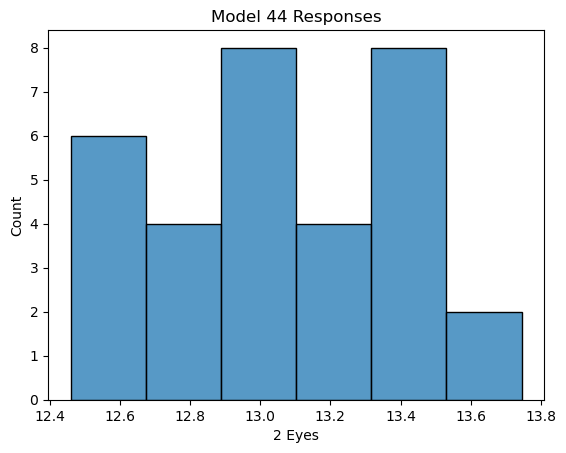

In [9]:
for i in range(population_size):
    series = extract_population_response(df_feature_combination, i, "2 Eyes")
    plt.figure()
    plt.title(f"Model {i} Responses")
    sns.histplot(series)
    plt.show()

# ANOVA

In [51]:
df_anova = pd.melt(df_mean_responses.reset_index(), id_vars=['model_idx'], value_vars=df_feature_combination.columns)
df_anova.columns = ["model_idx", "feature_combination", "mean"]
df_anova.head()

,model_idx,feature_combination,mean
0,0,1 Eye,15.022188
1,1,1 Eye,15.276094
2,2,1 Eye,15.157500
3,3,1 Eye,16.957500
4,4,1 Eye,14.797187


In [52]:
res = pg.rm_anova(data=df_anova, dv='mean', within='feature_combination', subject='model_idx', 
                  correction=True, detailed=False)
res

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,feature_combination,7,308,655.884366,7.032661e-181,1.851172e-69,0.658926,0.374624,True,117828.514097,1.0


## Check Assumptions for ANOVA

In [53]:
pg.sphericity(data=df_anova, dv='mean', within='feature_combination', subject='model_idx')

SpherResults(spher=True, W=117828.5140970909, chi2=-484.0388544744033, dof=27, pval=1.0)

In [54]:
#pg.normality(data=df_anova, dv='mean', group='feature_combination', alpha=0.05/8)
pg.normality(data=df_anova, dv='mean', group='feature_combination', alpha=0.05)

,W,pval,normal
feature_combination,,,
1 Eye,0.965664,0.200260,True
2 Eyes,0.927724,0.007801,False
"1 Eye, Nose",0.978413,0.556800,True
"1 Eye, Mouth",0.976718,0.493095,True
"2 Eyes, Nose",0.967010,0.224850,True
"1 Eye, Nose, Mouth",0.977985,0.540330,True
Full Face,0.978656,0.566282,True
"2 Eyes, Mouth",0.966466,0.214591,True


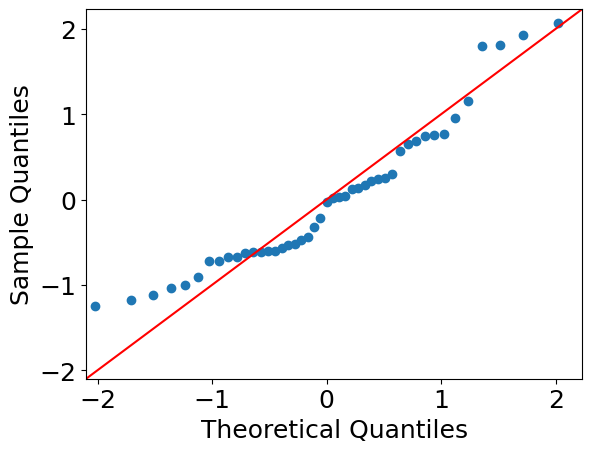

In [55]:
sm.qqplot(df_mean_responses["2 Eyes"]-df_mean_responses["2 Eyes"].mean(), line='45')
plt.show()

## Pairwise t-Tests

In [56]:
post_hocs = pg.pairwise_tests(data=df_anova, dv='mean', within='feature_combination', subject='model_idx', 
                              padjust='bonf', alternative='two-sided')
post_hocs[post_hocs.B=="Full Face"]
post_hocs

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,feature_combination,1 Eye,"1 Eye, Mouth",True,True,27.051838,44.0,two-sided,4.691362e-29,1.313581e-27,bonf,5.662e+25,1.877753
1,feature_combination,1 Eye,"1 Eye, Nose",True,True,20.773277,44.0,two-sided,2.269531e-24,6.354688e-23,bonf,1.552e+21,0.955484
2,feature_combination,1 Eye,"1 Eye, Nose, Mouth",True,True,33.855315,44.0,two-sided,3.784655e-33,1.059703e-31,bonf,5.552e+29,2.786394
3,feature_combination,1 Eye,2 Eyes,True,True,24.805446,44.0,two-sided,1.690659e-27,4.733845e-26,bonf,1.722e+24,1.799493
4,feature_combination,1 Eye,"2 Eyes, Mouth",True,True,35.331875,44.0,two-sided,6.174409e-34,1.728835e-32,bonf,3.256e+30,3.583598
5,feature_combination,1 Eye,"2 Eyes, Nose",True,True,30.541833,44.0,two-sided,2.934339e-31,8.216149e-30,bonf,7.97e+27,2.672727
6,feature_combination,1 Eye,Full Face,True,True,39.183557,44.0,two-sided,7.465163e-36,2.090246e-34,bonf,2.421e+32,4.346532
7,feature_combination,"1 Eye, Mouth","1 Eye, Nose",True,True,-10.887284,44.0,two-sided,4.550989e-14,1.274277e-12,bonf,1.623e+11,-0.889231
8,feature_combination,"1 Eye, Mouth","1 Eye, Nose, Mouth",True,True,21.228259,44.0,two-sided,9.520827e-25,2.665832e-23,bonf,3.615e+21,1.011098
9,feature_combination,"1 Eye, Mouth",2 Eyes,True,True,-0.001198,44.0,two-sided,9.990499e-01,1.000000e+00,bonf,0.162,-0.000114


In [74]:
print(f"Treatment A & Treatment B & $p$-value & DOF & $T$\\\\")
print("\\hline")
for row in post_hocs.iterrows():
    row = row[1]
    print(f"{row['A']} & {row['B']} & ${row['p-corr']}$ & ${int(row['dof'])}$ & ${row['T']:.2f}$\\\\")

Treatment A & Treatment B & $p$-value & DOF & $T$\\
\hline
1 Eye & 1 Eye, Mouth & $1.3135814966061585e-27$ & $44$ & $27.05$\\
1 Eye & 1 Eye, Nose & $6.354688076476328e-23$ & $44$ & $20.77$\\
1 Eye & 1 Eye, Nose, Mouth & $1.0597033040688336e-31$ & $44$ & $33.86$\\
1 Eye & 2 Eyes & $4.733845074505796e-26$ & $44$ & $24.81$\\
1 Eye & 2 Eyes, Mouth & $1.7288345720693003e-32$ & $44$ & $35.33$\\
1 Eye & 2 Eyes, Nose & $8.216149051244092e-30$ & $44$ & $30.54$\\
1 Eye & Full Face & $2.090245708679966e-34$ & $44$ & $39.18$\\
1 Eye, Mouth & 1 Eye, Nose & $1.2742769957965882e-12$ & $44$ & $-10.89$\\
1 Eye, Mouth & 1 Eye, Nose, Mouth & $2.6658316758171003e-23$ & $44$ & $21.23$\\
1 Eye, Mouth & 2 Eyes & $1.0$ & $44$ & $-0.00$\\
1 Eye, Mouth & 2 Eyes, Mouth & $9.769795477719851e-27$ & $44$ & $25.77$\\
1 Eye, Mouth & 2 Eyes, Nose & $4.4092074570795124e-10$ & $44$ & $9.00$\\
1 Eye, Mouth & Full Face & $4.8052644076003965e-30$ & $44$ & $30.93$\\
1 Eye, Nose & 1 Eye, Nose, Mouth & $1.0758180959532562e-27

# 1 Parafoveal Feature

In [15]:
results = pairwise_anova(df_anova, ["2 Eyes", "1 Eye, Nose", "1 Eye, Mouth"], 
                         dv='mean', within='feature_combination', subject='model_idx', 
                         correction=True, detailed=True)

In [16]:
for result in results:
    print(f"{result[0]} and {result[1]} gives")
    try:
        print("\t", result[2]["p-GG-corr"][0])
    except:
        print("\t", result[2]["p-unc"][0])

2 Eyes and 1 Eye, Nose gives
	 4.0875247425878856e-14
2 Eyes and 1 Eye, Mouth gives
	 0.9990499062464758
1 Eye, Nose and 1 Eye, Mouth gives
	 4.5509892707023604e-14


# 2 Parafoveal Features

In [17]:
results = pairwise_anova(df_anova, ["2 Eyes, Nose", "1 Eye, Nose, Mouth", "2 Eyes, Mouth"], 
                         dv='mean', within='feature_combination', subject='model_idx', 
                         correction=True, detailed=True)

In [18]:
for result in results:
    print(f"{result[0]} and {result[1]} gives")
    try:
        print("\t", result[2]["p-GG-corr"][0])
    except:
        print("\t", result[2]["p-unc"][0])

2 Eyes, Nose and 1 Eye, Nose, Mouth gives
	 0.9069249623007876
2 Eyes, Nose and 2 Eyes, Mouth gives
	 2.604758831984089e-14
1 Eye, Nose, Mouth and 2 Eyes, Mouth gives
	 4.243699737864664e-15


# Parafoveal Feature Count

In [75]:
df_parafoveal = pd.DataFrame(0, index=np.arange(population_size), columns=["0 Parafoveal Features",
                                                                          "1 Parafoveal Features",
                                                                          "2 Parafoveal Features",
                                                                          "3 Parafoveal Features",
                                                                          "model_idx"])
for model_idx in range(population_size):
    df_parafoveal.at[model_idx, "0 Parafoveal Features"] = df_mean_responses["1 Eye"].iloc[model_idx]
    df_parafoveal.at[model_idx, "1 Parafoveal Features"] = df_mean_responses[["2 Eyes", "1 Eye, Nose", "1 Eye, Mouth"]].iloc[model_idx].mean()
    df_parafoveal.at[model_idx, "2 Parafoveal Features"] = df_mean_responses[["2 Eyes, Nose", "1 Eye, Nose, Mouth", "2 Eyes, Mouth"]].iloc[model_idx].mean()
    df_parafoveal.at[model_idx, "3 Parafoveal Features"] = df_mean_responses["Full Face"].iloc[model_idx]
    df_parafoveal.at[model_idx, "model_idx"] = model_idx

In [88]:
df_parafoveal = pd.DataFrame()

df_parafoveal["0 Parafoveal Features"] = df_mean_responses["1 Eye"]

new_df = pd.DataFrame()
new_df["1 Parafoveal Feature"] = pd.concat([df_mean_responses["2 Eyes"], df_mean_responses["1 Eye, Nose"], df_mean_responses["1 Eye, Mouth"]], 
                                        ignore_index=True)
df_parafoveal = pd.concat([df_parafoveal, new_df], axis=1)

new_df = pd.DataFrame()
new_df["2 Parafoveal Features"] = pd.concat([df_mean_responses["2 Eyes, Nose"], df_mean_responses["1 Eye, Nose, Mouth"], df_mean_responses["2 Eyes, Mouth"]], 
                                        ignore_index=True)
df_parafoveal = pd.concat([df_parafoveal, new_df], axis=1)

new_df = pd.DataFrame()
new_df["3 Parafoveal Features"] = df_mean_responses["Full Face"]
df_parafoveal = pd.concat([df_parafoveal, new_df], axis=1)

new_df = pd.DataFrame()
new_df["model_idx"] = pd.Series([i for i in range(3*population_size)])
df_parafoveal = pd.concat([df_parafoveal, new_df], axis=1)

df_parafoveal = df_parafoveal.replace([np.inf, -np.inf], np.nan)

In [89]:
df_parafoveal.head()

,0 Parafoveal Features,1 Parafoveal Feature,2 Parafoveal Features,3 Parafoveal Features,model_idx
0,15.022188,12.824687,11.995312,10.950937,0
1,15.276094,12.920937,11.990000,10.910000,1
2,15.157500,12.934375,12.153750,11.240937,2
3,16.957500,14.315156,13.484219,11.980937,3
4,14.797187,13.016250,12.213750,11.175469,4


## Plotting

In [90]:
temp_cols = ['0 Parafoveal Features', '1 Parafoveal Feature',
       '2 Parafoveal Features', '3 Parafoveal Features']

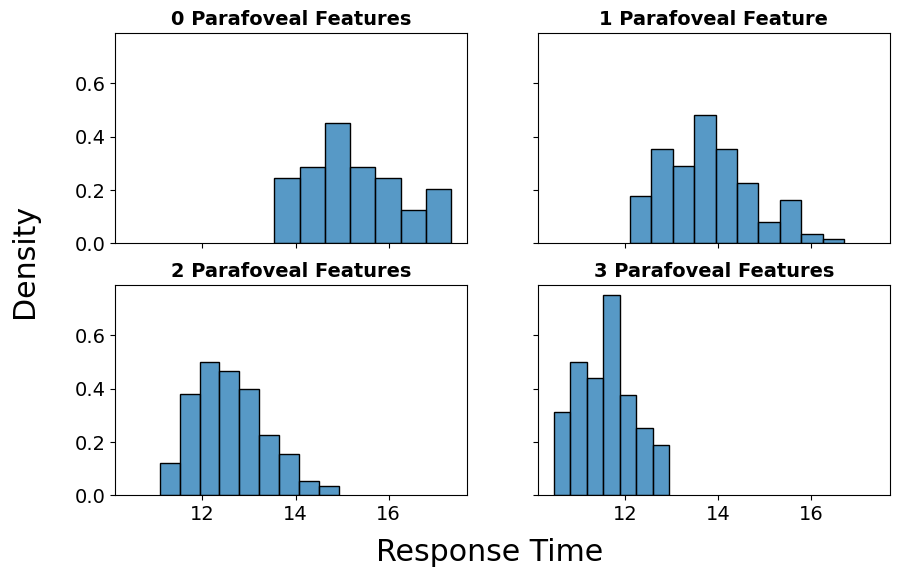

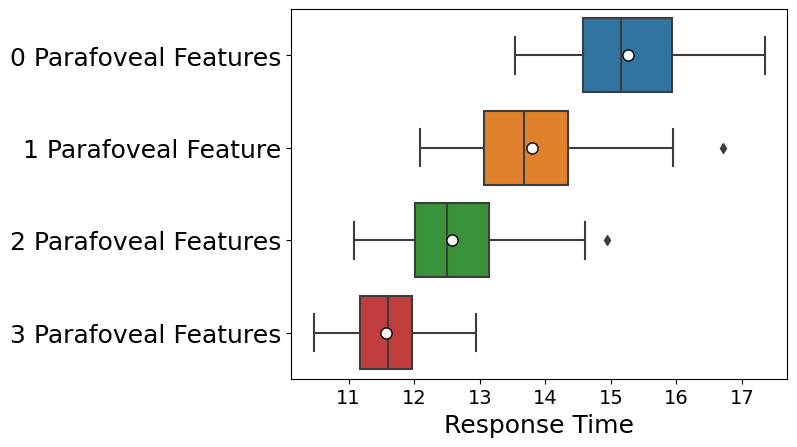

In [91]:
include_outliers = True

if include_outliers: #include everything
    df_subset = df_parafoveal[temp_cols]
else:
    df_subset = df_parafoveal[temp_cols].copy()
    for col in df_subset.columns:
        indices = extract_outliers(df_subset[col])
        df_subset[col][indices] = np.nan

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 6))

sns.histplot(df_subset, x=df_subset.columns[0], stat="density", ax=axes[0, 0]).set(ylabel="")
axes[0, 0].set_title(df_subset.columns[0], fontsize=14, weight='bold')
axes[0, 0].set_xlabel("")
axes[0, 0].set_ylabel("")

sns.histplot(df_subset, x=df_subset.columns[1], stat="density", ax=axes[0, 1]).set(ylabel="")
axes[0, 1].set_title(df_subset.columns[1], fontsize=14, weight='bold')
axes[0, 1].set_xlabel("")
axes[0, 1].set_ylabel("")

sns.histplot(df_subset, x=df_subset.columns[2], stat="density", ax=axes[1, 0]).set(ylabel="")
axes[1, 0].set_title(df_subset.columns[2], fontsize=14, weight='bold')
axes[1, 0].set_xlabel("")
axes[0, 1].set_ylabel("")

sns.histplot(df_subset, x=df_subset.columns[3], stat="density", ax=axes[1, 1]).set(ylabel="")
axes[1, 1].set_title(df_subset.columns[3], fontsize=14, weight='bold')
axes[1, 1].set_xlabel("")
axes[0, 1].set_ylabel("")

#axes[-1, 0].set_xlabel("Response Time", fontsize=default_font_size)
#axes[-1, 1].set_xlabel("Response Time", fontsize=default_font_size)
#axes[0, 0].set_ylabel("Density", fontsize=default_font_size)
#axes[1, 0].set_ylabel("Density", fontsize=default_font_size)
fig.supylabel("Density")
fig.supxlabel("Response Time", y=-0.01)
for ax in axes.flatten():
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
plt.savefig("para_hist.svg", format="svg")
plt.show()

#boxplot

fig, ax = plt.subplots()
sns.boxplot(df_parafoveal[temp_cols], orient="h", showfliers=include_outliers,
            showmeans=True,
            meanprops={'marker':'o',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'})
#ax.tick_params(axis='x', labelrotation=30)
#plt.title(f"{args.test_convergence_norm} Convergence", fontsize=14, weight="bold")
plt.xlabel("Response Time", fontsize=default_font_size)
ax.tick_params(axis='x', labelsize=14)
#ax.tick_params(axis='y', labelsize=14)
plt.savefig("para_boxplot.svg", format="svg")
plt.show()

In [92]:
for col in temp_cols:
    print(f"{col} & {df_parafoveal[col].mean():.2f} & {df_parafoveal[col].std():.2f} \\\\")

0 Parafoveal Features & 15.26 & 1.02 \\
1 Parafoveal Feature & 13.80 & 0.93 \\
2 Parafoveal Features & 12.58 & 0.77 \\
3 Parafoveal Features & 11.57 & 0.60 \\


In [113]:
from scipy.stats import skew
skew(df_parafoveal["1 Parafoveal Feature"].to_numpy())

0.545257489728488

15.146 [-1.229]


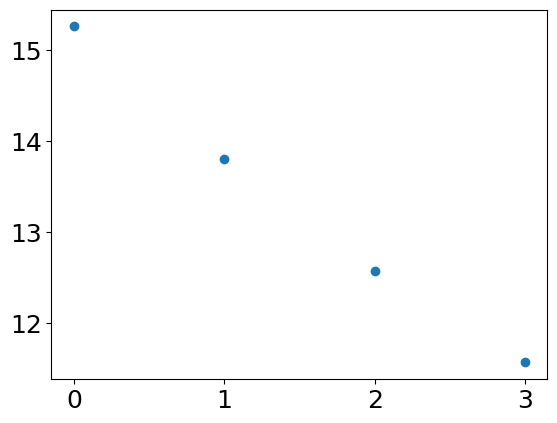

In [108]:
from sklearn.linear_model import LinearRegression
x = np.array([0, 1, 2, 3]).reshape((-1, 1))
y = np.array([15.26, 13.80, 12.58, 11.57])
model = LinearRegression()
model.fit(x, y)
print(model.intercept_, model.coef_)
plt.scatter([0, 1, 2, 3], [15.26, 13.80, 12.58, 11.57])

## Anova

In [102]:
df_parafoveal_anova = pd.melt(df_parafoveal.reset_index(), id_vars=['model_idx'], value_vars=df_parafoveal.columns)
df_parafoveal_anova.columns = ["model_idx", "parafovea", "mean"]
df_parafoveal_anova.head(400)

,model_idx,parafovea,mean
0,0,0 Parafoveal Features,15.022188
1,1,0 Parafoveal Features,15.276094
2,2,0 Parafoveal Features,15.157500
3,3,0 Parafoveal Features,16.957500
4,4,0 Parafoveal Features,14.797187
...,...,...,...
395,125,2 Parafoveal Features,12.164219
396,126,2 Parafoveal Features,12.385781
397,127,2 Parafoveal Features,12.331406
398,128,2 Parafoveal Features,13.597656


In [94]:
res = pg.rm_anova(data=df_parafoveal_anova, dv='mean', within='parafovea', subject='model_idx', 
                  correction=True, detailed=True)
res

,Source,SS,DF,MS,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,parafovea,321.357635,3,107.119212,1070.81192,2.035363e-92,1.440442e-53,0.72402,0.567344,False,0.260683,4.214335e-11
1,Error,13.204687,132,0.100036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Check Assumptions

In [95]:
pg.sphericity(data=df_parafoveal_anova, dv='mean', within='parafovea', subject='model_idx')

SpherResults(spher=False, W=0.26068333153989365, chi2=57.4378445615614, dof=5, pval=4.214334804690515e-11)

In [96]:
pg.normality(data=df_parafoveal_anova, dv='mean', group='parafovea', alpha=0.05)
#pg.normality(data=df_parafoveal_anova, dv='mean', group='parafovea', alpha=0.05/4)

,W,pval,normal
parafovea,,,
0 Parafoveal Features,0.965664,0.200260,True
1 Parafoveal Feature,0.972340,0.007500,False
2 Parafoveal Features,0.981827,0.068730,True
3 Parafoveal Features,0.978656,0.566282,True


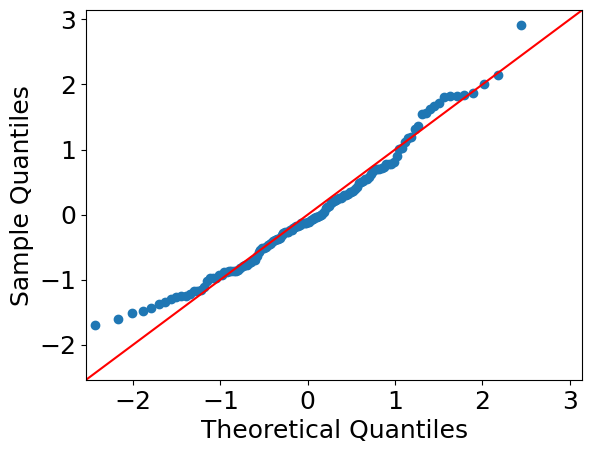

In [97]:
sm.qqplot(df_parafoveal["1 Parafoveal Feature"]-df_parafoveal["1 Parafoveal Feature"].mean(), line='45')
plt.show()

## Pairwise t-Tests

In [98]:
post_hocs = pg.pairwise_tests(data=df_parafoveal_anova, dv='mean', within='parafovea', subject='model_idx', 
                              padjust='bonf', alternative='two-sided')
post_hocs[post_hocs.B=="3 Parafoveal Features"]
post_hocs

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,parafovea,0 Parafoveal Features,1 Parafoveal Feature,True,True,24.805446,44.0,two-sided,1.690659e-27,1.014395e-26,bonf,1.722e+24,1.799493
1,parafovea,0 Parafoveal Features,2 Parafoveal Features,True,True,30.541833,44.0,two-sided,2.934339e-31,1.760603e-30,bonf,7.97e+27,2.672727
2,parafovea,0 Parafoveal Features,3 Parafoveal Features,True,True,39.183557,44.0,two-sided,7.465163e-36,4.479098e-35,bonf,2.421e+32,4.346532
3,parafovea,1 Parafoveal Feature,2 Parafoveal Features,True,True,21.456210,44.0,two-sided,6.196759e-25,3.718055e-24,bonf,5.49e+21,0.907443
4,parafovea,1 Parafoveal Feature,3 Parafoveal Features,True,True,34.303601,44.0,two-sided,2.165896e-33,1.299537e-32,bonf,9.57e+29,2.632649
5,parafovea,2 Parafoveal Features,3 Parafoveal Features,True,True,27.470602,44.0,two-sided,2.476344e-29,1.485806e-28,bonf,1.055e+26,1.701875


In [103]:
print(f"Treatment A & Treatment B & $p$-value & DOF & $T$\\\\")
print("\\hline")
for row in post_hocs.iterrows():
    row = row[1]
    print(f"{row['A']} & {row['B']} & ${row['p-corr']}$ & ${int(row['dof'])}$ & ${row['T']:.2f}$\\\\")

Treatment A & Treatment B & $p$-value & DOF & $T$\\
\hline
0 Parafoveal Features & 1 Parafoveal Feature & $1.0143953731083848e-26$ & $44$ & $24.81$\\
0 Parafoveal Features & 2 Parafoveal Features & $1.760603368123734e-30$ & $44$ & $30.54$\\
0 Parafoveal Features & 3 Parafoveal Features & $4.479097947171356e-35$ & $44$ & $39.18$\\
1 Parafoveal Feature & 2 Parafoveal Features & $3.7180551121445066e-24$ & $44$ & $21.46$\\
1 Parafoveal Feature & 3 Parafoveal Features & $1.2995373073020005e-32$ & $44$ & $34.30$\\
2 Parafoveal Features & 3 Parafoveal Features & $1.4858063047279785e-28$ & $44$ & $27.47$\\


## Pairwise ANOVA

In [30]:
results = pairwise_anova(df_parafoveal_anova, ['0 Parafoveal Features', '1 Parafoveal Features',
                         '2 Parafoveal Features', '3 Parafoveal Features'], 
                         dv='mean', within='parafovea', subject='model_idx', 
                         correction=True, detailed=True)

In [31]:
for result in results:
    print(f"{result[0]} and {result[1]} gives")
    try:
        print("\t", result[2]["p-GG-corr"][0])
    except:
        print("\t", result[2]["p-unc"][0])

0 Parafoveal Features and 1 Parafoveal Features gives
	 2.7801855065988087e-35
0 Parafoveal Features and 2 Parafoveal Features gives
	 1.2308130088991985e-36
0 Parafoveal Features and 3 Parafoveal Features gives
	 8.080354742292325e-38
1 Parafoveal Features and 2 Parafoveal Features gives
	 2.0994755414423397e-38
1 Parafoveal Features and 3 Parafoveal Features gives
	 1.0590322258848192e-39
2 Parafoveal Features and 3 Parafoveal Features gives
	 2.1208538143108464e-41
